In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
# Set to LateX
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amsfonts}\usepackage{amssymb}"
})

In [2]:
# Select 2 or 3
dim_problem = 3

In [3]:
# Prepare to read multiple result files
testname = 'EPSvsNt1'
base_dir = os.path.abspath(os.path.join(os.getcwd(), ''))
problem_name = f'AdvDiff{dim_problem}D'

/tmp/ipykernel_38255/1624448176.py:176: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


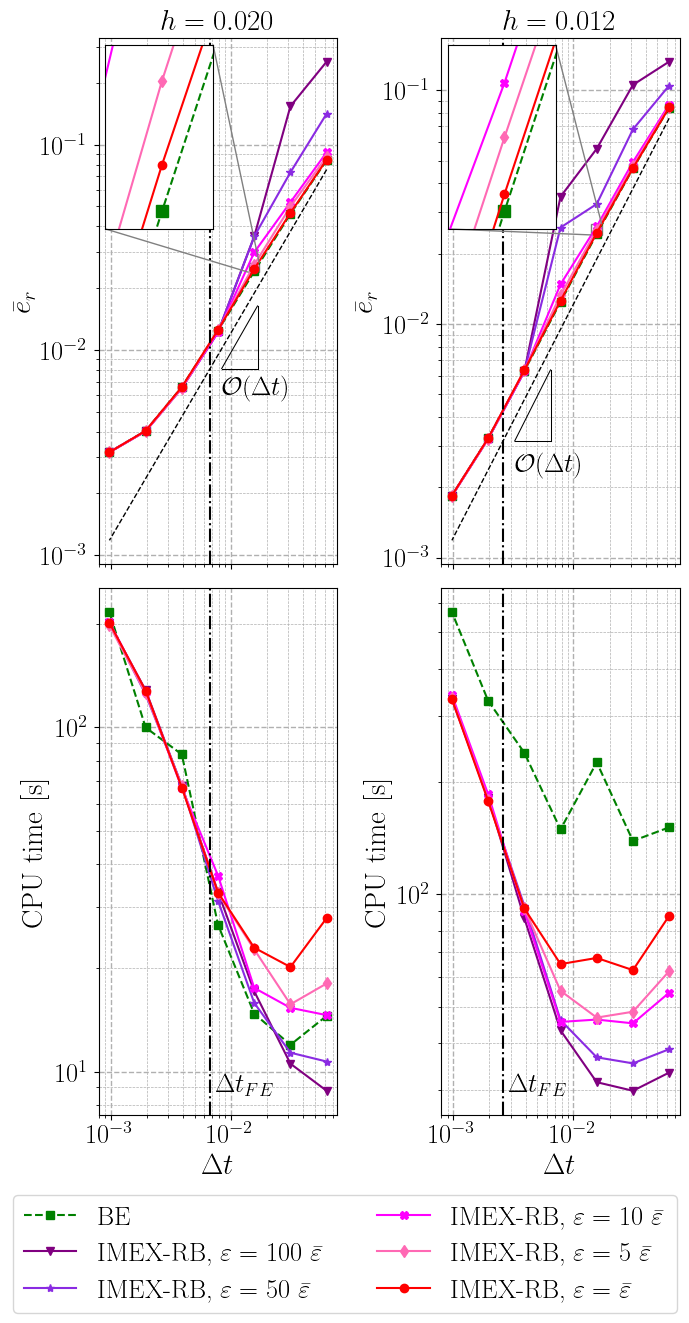

In [4]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

fig, axs = plt.subplots(2, 2, figsize=(7, 12), sharex=True)

# Plotting styles
all_markers = ['v', '*', 'X', 'd', 'o', 'p', 's', 'h']
all_colors = ['purple', 'blueviolet', 'magenta', 'hotpink',
              'red', 'maroon', 'teal', 'orange']
all_labels = [
    r"IMEX-RB, $\varepsilon = 100 \ \bar{\varepsilon}$",
    r"IMEX-RB, $\varepsilon = 50 \ \bar{\varepsilon}$",
    r"IMEX-RB, $\varepsilon = 10 \ \bar{\varepsilon}$",
    r"IMEX-RB, $\varepsilon = 5 \ \bar{\varepsilon}$",
    r"IMEX-RB, $\varepsilon = \bar{\varepsilon}$",
    r"IMEX-RB, $\varepsilon = 0.1 \ \bar{\varepsilon}$",
    r"IMEX-RB, $\varepsilon = 0.01 \ \bar{\varepsilon}$",
    r"IMEX-RB, $\varepsilon = 0.001 \ \bar{\varepsilon}$"
]
larger_fontsize = 21
smaller_fontsize = 19

# Load the single results file which now contains data for all Nx_values
results_path = os.path.join(
    base_dir,
    os.pardir,
    os.pardir,
    '__RESULTS',
    problem_name,
    testname,
    'results.npz'
)
results = np.load(results_path, allow_pickle=True)
Nx_values = results['Nx_values']         # array of grid sizes, length 2
Nts = results['Nt_values']               # timestep values
errBE_all = results['errors_l2'].item()['BE']         # shape: (len(Nts), len(Nx_values))
errIMEX_all = results['errors_l2'].item()['IMEX-RB']  # shape: (len(Nts), nIMEX, len(Nx_values))
timesBE_all = results['times'].item()['BE']           # shape: (len(Nts), len(Nx_values))
timesIMEX_all = results['times'].item()['IMEX-RB']    # shape: (len(Nts), nIMEX, len(Nx_values))
subiters_all = results['subiters'].item()['IMEX-RB']  # shape: (len(Nts), nIMEX, max_Nt, len(Nx_values))
Nt_FE_all = results['Nt_FE']           # array of FE stability thresholds, length len(Nx_values)

nIMEX = errIMEX_all.shape[1]  # number of epsilon cases


# Plot
for col, Nx in enumerate(Nx_values):

    ax_err = axs[0, col]

    ax_err.set_title(rf"$h = {1/Nx:.3f}$",
                     fontsize=larger_fontsize)

    # Extract data for this grid size
    errBE = errBE_all[:, col]
    errIMEX = errIMEX_all[:, :, col]
    timesBE = timesBE_all[:, col]
    timesIMEX = timesIMEX_all[:, :, col]
    Nt_FE = Nt_FE_all[col]

    # Top subplot: relative error with inset
    ax_err = axs[0, col]
    ax_err.loglog(1 / Nts, errBE, 's', linestyle='--',
                  markersize=6, color='green', label='BE')
    for idx in range(nIMEX):
        m = all_markers[idx]
        c = all_colors[idx]
        lbl = all_labels[idx]
        ax_err.loglog(1 / Nts, errIMEX[:, idx],
                      f'-{m}', markersize=6, color=c, label=lbl)
    # Reference O(Δt) line
    ax_err.loglog(1 / Nts,  (Nts[0] * errBE[0] * 0.9)  / Nts,
                  color='k', linestyle='--', linewidth=1)
    x_fe = 1 / Nt_FE
    ax_err.axvline(x_fe, color='k', linestyle='-.')
    # Reference slope triangle
    xmin, xmax = ax_err.get_xlim()
    ymin, ymax = ax_err.get_ylim()
    lxmin, lxmax = np.log10(xmin), np.log10(xmax)
    lymin, lymax = np.log10(ymin), np.log10(ymax)
    fx = 0.05
    lx0 = np.log10(x_fe) + fx * (lxmax - lxmin)
    x0 = 10**lx0
    c_ref = Nts[0] * errBE[0] * 0.9
    y_line0 = c_ref * x0
    offset_y = 0.2
    y0 = y_line0 * (1 - offset_y)
    dx_frac = 0.15
    lx_dx = dx_frac * (lxmax - lxmin)
    dx = 10**(lx0 + lx_dx) - x0
    dy = dx
    ax_err.plot([x0, x0 + dx], [y0, y0], 'k-', lw=0.75)
    ax_err.plot([x0 + dx, x0 + dx], [y0, y0 + dy], 'k-', lw=0.75)
    ax_err.plot([x0 + dx, x0], [y0 + dy, y0], 'k-', lw=0.75)
    xm = x0
    ym = y0 - 0.3 * dy
    ax_err.text(
        xm, ym,
        r"$\mathcal{O}(\Delta t)$",
        fontsize=smaller_fontsize,
        ha='left', va='bottom'
    )
    # Zoom-in: inset
    loc = ('upper left' if col == 0 else 'lower right') if dim_problem==2 else 'upper left'
    axins = inset_axes(
        ax_err, width="45%", height="35%",
        loc=loc, bbox_to_anchor=(0,0,1,1),
        bbox_transform=ax_err.transAxes
    )
    axins.loglog(1/Nts, errBE, 's', ms=8, ls="--", color='green')
    for idx in range(nIMEX):
        axins.loglog(1/Nts, errIMEX[:, idx], f"-{all_markers[idx]}", ms=6, color=all_colors[idx])
    # focus index
    focus = 2
    pad = 0.1 
    x0 = 1/Nts[focus]
    axins.set_xlim(x0*(1 - pad), x0*(1 + pad))
    y0 = errBE[focus]
    axins.set_ylim(y0*(1 - 0.1*pad), y0*(1 + pad))
    axins.tick_params(
        axis='both', which='both',
        bottom=False, top=False,
        left=False, right=False,
        labelbottom=False, labelleft=False
    )
    mark_inset(ax_err, axins, loc1=1, loc2=3, fc="none", ec="0.5")

    ax_err.grid(which='major', linewidth=1, linestyle='--')
    ax_err.grid(which='minor', linewidth=0.5, linestyle='--')
    ax_err.tick_params(axis='both', which='major', labelsize=smaller_fontsize)
    ax_err.set_ylabel(r"$\bar{e}_r$", fontsize=larger_fontsize)

    # Bottom subplot: CPU time
    ax_time = axs[1, col]
    ax_time.loglog(1 / Nts, timesBE, '--s', markersize=6,
                   color='green', label='BE')
    for idx in range(nIMEX):
        m = all_markers[idx]
        c = all_colors[idx]
        lbl = all_labels[idx]
        ax_time.loglog(1 / Nts, timesIMEX[:, idx],
                       f'-{m}', markersize=6, color=c, label=lbl)

    ax_time.axvline(1 / Nt_FE, color='k', linestyle='-.')
    xmin, xmax = ax_time.get_xlim()
    ymin, ymax = ax_time.get_ylim()
    lxmin, lxmax = np.log10(xmin), np.log10(xmax)
    lymin, lymax = np.log10(ymin), np.log10(ymax)
    # fraction up the *log* y‐axis
    f_y = 0.08
    f_x = 0.02
    lxfe = np.log10(x_fe)
    x_text = 10 ** (lxfe + f_x * (lxmax - lxmin))
    y_text = 10 ** (lymin + f_y * (lymax - lymin))
    ax_time.text(
        x_text, y_text,
        r"$\Delta t_{FE}$",
        fontsize=smaller_fontsize,
        ha='left', va='top'
    )
    ax_time.tick_params(axis='both', which='major', labelsize=smaller_fontsize)
    ax_time.grid(which='major', linestyle='--', linewidth=1)
    ax_time.grid(which='minor', linestyle='--', linewidth=0.5)
    ax_time.set_xlabel(r"$\Delta t$", fontsize=larger_fontsize)
    ax_time.set_ylabel("CPU time [s]", fontsize=larger_fontsize)

# External legend for both error and time plots
handles, labels = axs[1, 0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.11),
    fontsize=smaller_fontsize,
    ncol=2
)
plt.tight_layout()
plt.savefig('plots/' + f'{problem_name}_' + f'convergence_times_eps.pdf', bbox_inches="tight")


### Process subiterations for a given space discretization
Look at average inner iterations varying $\Delta t$ and iterations over time
for one $\Delta t$

In [7]:
# Read now a single result file, i.e. a single Nx
col = 0 if dim_problem==2 else 1
# Extract data for this grid size
errBE = errBE_all[:, col]
errIMEX = errIMEX_all[:, :, col]
timesBE = timesBE_all[:, col]
timesIMEX = timesIMEX_all[:, :, col]
Nt_FE = Nt_FE_all[col]
subiters = subiters_all[:, :, :, col]
# Masking sub-iterations
mask = np.zeros_like(subiters, dtype=bool)
for i, _Nt in enumerate(Nts):
    mask[i, :, :_Nt] = True
masked_subiters = np.ma.masked_array(subiters, mask=~mask)

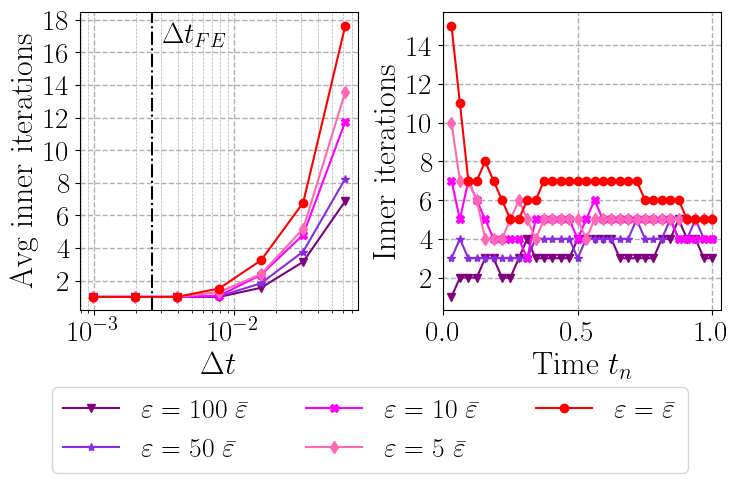

In [8]:
# Range for epsilon cases are available
indices = list(range(nIMEX))
larger_fontsize = 23
smaller_fontsize = 21

all_labels_mod = [
    r"$\varepsilon = 100 \ \bar{\varepsilon}$",
    r"$\varepsilon = 50 \ \bar{\varepsilon}$",
    r"$\varepsilon = 10 \ \bar{\varepsilon}$",
    r"$\varepsilon = 5 \ \bar{\varepsilon}$",
    r"$\varepsilon = \bar{\varepsilon}$",
    r"$\varepsilon = 0.1 \ \bar{\varepsilon}$",
    r"$\varepsilon = 0.01 \ \bar{\varepsilon}$",
    r"$\varepsilon = 0.001 \ \bar{\varepsilon}$"
]

markers = all_markers[:nIMEX]
colors = all_colors[:nIMEX]
labels = all_labels_mod[:nIMEX]

fig, axs = plt.subplots(1, 2, figsize=(7.5, 4))

# Left subplot: average inner iterations vs Δt
ax = axs[0]
for idx, m, c, lbl in zip(indices, markers, colors, labels):
    mean_iter = np.mean(masked_subiters[:, idx] + 1, axis=-1)
    ax.semilogx(
        1 / Nts,
        mean_iter,
        f'-{m}',
        markersize=6,
        color=c,
        label=lbl
    )
ax.axvline(1 / Nt_FE, color='k', linestyle='-.')
ymin, ymax = ax.get_ylim()
ax.text(1 / Nt_FE * 1.2, 0.9*ymax, r"$\Delta t_{FE}$", fontsize=smaller_fontsize, color='k')
ax.grid(which='major', linestyle='--', linewidth=1)
ax.grid(which='minor', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=smaller_fontsize)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel(r"$\Delta t$", fontsize=larger_fontsize)
ax.set_ylabel("Avg inner iterations", fontsize=larger_fontsize)

# Right subplot: inner iterations vs time for Nt_idx = 1
ax = axs[1]
Nt_idx = 1
tvec = np.linspace(0, 1, Nts[Nt_idx] + 1)[1:]
for idx, m, c, lbl in zip(indices, markers, colors, labels):
    ax.plot(
        tvec,
        subiters[Nt_idx, idx, :Nts[Nt_idx]] + 1,
        f'-{m}',
        markersize=6,
        color=c,
        label=lbl
    )
ax.grid(which='major', linestyle='--', linewidth=1)
ax.set_xlim([0, 1 + 1 / Nts[Nt_idx]])
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.tick_params(axis='both', which='major', labelsize=smaller_fontsize)
ax.set_xlabel(r"Time $t_n$", fontsize=larger_fontsize)
ax.set_ylabel("Inner iterations", fontsize=larger_fontsize)

# Single external legend on the right, one column
handles, legend_labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles,
    legend_labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.23),
    fontsize=smaller_fontsize-1,
    ncol=3
)

plt.tight_layout()
plt.savefig('plots/' + f'{problem_name}_' + f'iters_eps_Nx_{Nx_values[col]}.pdf', bbox_inches="tight")